# Aging Norm Excursion

## Notebook description

This notebook analyzes the Aging clincial trial study. The analysis is performed using advanced stats code library.

We use range of statistical techniques like weekly treatment effect visualization, daily treatment effect visualization, t-test, Mann Whitney test, fraction of outlier plot, confidence interval, binomial test, randomization test and effect size to understand the treatment effect in the Aging study. Finally, we interpret the Norm Excursion model using one class svm decision boundaries to intuitively understand the treatment effect for every patient in the Aging study.

## Input data
1) `AGING_DATA_EXTRACT__NEW_NQSD_20231214.csv`

In [1]:
# import necessary packages
import sys, os
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.pylab import plt
from sklearn.preprocessing import MinMaxScaler

scripts_master = os.path.dirname('../../advanced_stats_code_library/src/')
sys.path.insert(0, scripts_master) 

# import modules from the advanced stats code library
from responder_analysis import responder_utils
from norm_excursion.report_results import ReportResults
from norm_excursion.norm_excursion import NormExcursion
from norm_excursion.study_meta_data import StudyMetaData
from norm_excursion.data_validation import DataValidation
from power_analysis.power_analysis import PowerAnalysis

# configurations for seaborn plots
palette = sns.color_palette('deep', 10)
plt.style.use('seaborn-whitegrid')
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
params = {
            'legend.fontsize': 'x-large',
            'axes.labelsize': 'x-large',
            'axes.titlesize':'x-large',
            'xtick.labelsize':'x-large',
            'ytick.labelsize':'x-large'
        }
plt.rcParams.update(params)

# model interpretation packages
from sklearn.svm import OneClassSVM
import matplotlib
from matplotlib import colors

# Man whitney unit test 
(should be removed from final deliverable)

In [2]:
from scipy import stats

wam_pop = np.array([37.])
non_wam_pop = np.array([ 40. , 161. ,  58.4,  78. ,  38. ,  48. , 133. ,  73. ])

# unit test to ensure we have the right mann_whitney test
assert(stats.mannwhitneyu(wam_pop, non_wam_pop)[1]==0.2222222222222222)

## Reading data extracts

In [3]:
data_nopop = pd.read_csv("gs://hpn_cte_advanced_stats_data_repository/yahui_data_repository/Aging 202312/AGING_DATA_EXTRACT__NEW_NQSD_20231214.csv")
population = pd.read_csv("gs://hpn_cte_advanced_stats_data_repository/yahui_data_repository/Aging 202312/population_updates_20231214.csv")

/opt/conda/envs/hillsadvancedml_envi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3258: DtypeWarning: Columns (640,642,646,653) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
aging_new_extract = pd.merge(data_nopop, population, on=['PET_ID'], how='left')

In [5]:
aging_new_extract['PET_ID'].nunique()

146

In [6]:
aging_new_extract.groupby('study_food')['PET_ID'].nunique()

study_food
Black    55
None     37
Peach    54
Name: PET_ID, dtype: int64

In [7]:
aging_new_extract.head()

,PET_ID,EXTERNAL_ID,DEVICE_ID,STUDY_ID,STUDY_NAME,PET_NAME,DATE,NORMALIZED_STUDY_DAY,NORMALIZED_QUALIFYING_STUDY_DAY,STUDY_DAY_COUNTER,STUDY_GROUP,BASELINE_START,START_DATE,ENROLLMENT_DATE,COMPLETION_DATE,END_DATE,EXCESSIVE_RUNNING,TIMEZONE,QUALIFYING_DATA_DAY,IS_QUALIFIED,DAILYDATAQUALITYINDREASON,VAR_TD_1_Q1_2,VAR_CE_1_Q1_2,VAR_MIN_1_Q1_2,VAR_MED_1_Q1_2,VAR_RANG_1_Q1_2,VAR_MAX_1_Q1_2,VAR_AVG_1_Q1_2,VAR_SD_1_Q1_2,VAR_IQR_1_Q1_2,VAR_ACE_1_Q1_2,VAR_SDCE_1_Q1_2,VAR_IQRCE_1_Q1_2,VAR_CE3SD_1_Q1_2,VAR_TD_3_Q1_2,VAR_CE_3_Q1_2,VAR_MIN_3_Q1_2,VAR_MED_3_Q1_2,VAR_RANG_3_Q1_2,VAR_MAX_3_Q1_2,VAR_AVG_3_Q1_2,VAR_SD_3_Q1_2,VAR_IQR_3_Q1_2,VAR_ACE_3_Q1_2,VAR_SDCE_3_Q1_2,VAR_IQRCE_3_Q1_2,VAR_CE3SD_3_Q1_2,VAR_TD_5_Q1_2,VAR_CE_5_Q1_2,VAR_MIN_5_Q1_2,VAR_MED_5_Q1_2,VAR_RANG_5_Q1_2,VAR_MAX_5_Q1_2,VAR_AVG_5_Q1_2,VAR_SD_5_Q1_2,VAR_IQR_5_Q1_2,VAR_ACE_5_Q1_2,VAR_SDCE_5_Q1_2,VAR_IQRCE_5_Q1_2,VAR_CE3SD_5_Q1_2,VAR_TD_4_Q1_2,VAR_CE_4_Q1_2,VAR_MIN_4_Q1_2,VAR_MED_4_Q1_2,VAR_RANG_4_Q1_2,VAR_MAX_4_Q1_2,VAR_AVG_4_Q1_2,VAR_SD_4_Q1_2,VAR_IQR_4_Q1_2,VAR_ACE_4_Q1_2,VAR_SDCE_4_Q1_2,VAR_IQRCE_4_Q1_2,VAR_CE3SD_4_Q1_2,VAR_TD_12_Q1_2,VAR_CE_12_Q1_2,VAR_MIN_12_Q1_2,VAR_MED_12_Q1_2,VAR_RANG_12_Q1_2,VAR_MAX_12_Q1_2,VAR_AVG_12_Q1_2,VAR_SD_12_Q1_2,VAR_IQR_12_Q1_2,VAR_ACE_12_Q1_2,VAR_SDCE_12_Q1_2,VAR_IQRCE_12_Q1_2,VAR_CE3SD_12_Q1_2,VAR_TD_2_Q1_2,VAR_CE_2_Q1_2,VAR_MIN_2_Q1_2,VAR_MED_2_Q1_2,VAR_RANG_2_Q1_2,VAR_MAX_2_Q1_2,VAR_AVG_2_Q1_2,VAR_SD_2_Q1_2,VAR_IQR_2_Q1_2,VAR_ACE_2_Q1_2,VAR_SDCE_2_Q1_2,VAR_IQRCE_2_Q1_2,VAR_CE3SD_2_Q1_2,VAR_TD_46_Q1_2,...,DER_LNG_5_Q5_2,DER_SHT_4_Q5_2,DER_MDM_4_Q5_2,DER_LNG_4_Q5_2,DER_CE_51_Q5_2,DER_RTO_52_Q5_2,DER_PRO_53_Q5_2,DER_PRO_54_Q5_2,DER_PRO_55_Q5_2,DER_PRO_56_Q5_2,DER_PRO_57_Q5_2,DER_PRO_58_Q5_2,DER_PRO_59_Q5_2,DER_PRO_60_Q5_2,DER_PRO_61_Q5_2,DER_PRO_62_Q5_2,CREATEDATE,VAR1_TD_8_Q1_2,VAR2_TD_8_Q1_2,VAR3_TD_8_Q1_2,VAR4_TD_8_Q1_2,VAR1_TD_8_Q2_2,VAR2_TD_8_Q2_2,VAR3_TD_8_Q2_2,VAR4_TD_8_Q2_2,VAR1_TD_8_Q3_2,VAR2_TD_8_Q3_2,VAR3_TD_8_Q3_2,VAR4_TD_8_Q3_2,VAR1_TD_8_Q4_2,VAR2_TD_8_Q4_2,VAR3_TD_8_Q4_2,VAR4_TD_8_Q4_2,VAR1_TD_8_Q5_2,VAR2_TD_8_Q5_2,VAR3_TD_8_Q5_2,VAR4_TD_8_Q5_2,DER_CE_63_Q5,VAR5_TD_8_Q1_6,VAR5_TD_8_Q2_6,VAR5_TD_8_Q3_6,VAR5_TD_8_Q4_6,VAR5_TD_8_Q5_6,IS_WEEKEND,CONSECUTIVE_RUNNING,CONSECUTIVE_SLEEP,sitename,BCS_SCORE-bcs_recorded_date,BCS_SCORE-body_condition_score,BODY_WEIGHTS-weight_recorded_date,BODY_WEIGHTS-entered_weight_lb,DEMOGRAPHICS-gender,DEMOGRAPHICS-date_of_birth,DEMOGRAPHICS-randomization_date_time,DEMOGRAPHICS-enroll_dog,DEMOGRAPHICS-d0_expected_date,DEMOGRAPHICS-latest_d0_avail_date,DEMOGRAPHICS-day0_date,DEMOGRAPHICS-day0_age,OWNER_DAILY_DAIRY - total_amount_time_walked,MEDICATION - medication,BODY_WEIGHTS-DAY0_BODY_WEIGHT,BCS_SCORE-DAY0_body_condition_score,clinical_itt,clinical_pp,questionnaire_itt_extract,walking_900,running_900,active_900,walking_300,running_300,active_300,walking_60,running_60,active_60,longest_running_event,longest_walking_event,active_periods_count_rolling,most_common_hour_rolling,active_periods_count_fixed,most_common_hour_fixed,patient_id,dog_and_owner_name,study_food,weight,mixed_breed,intact,sex,date_of_birth,baseline_mean_soft_stiction,treatment_mean_soft_stiction,IS_QUALIFIED_NEW,Qualifying_Data_Day_NEW,NORMALIZED_QUALIFYING_STUDY_DAY_NEW,wearables_itt,wearables_pp,wearables_itt_extract,wearables_pp_extract,itt_failure_reason,pp_failure_reason
0,3347,EPRO-QT-02,13034,1894,Aging Study,Bandit,10-09-2019,-30,NaN,22.0,Unassigned,10-10-2019,10-09-2019,10-10-2019,02-01-2020,05-02-2020,0,Central Standard Time,NaN,NO,Duration less than 20 hours,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.50,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.000000,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.000000,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.000000,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.000000,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.25,0.000000,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.00,0.18,0.82,0.00,0.0,0.0,0.18,0.82,0.00,0.0,0.0,19:41.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [8]:
aging_new_extract[(aging_new_extract['IS_QUALIFIED_NEW']=='YES') &\
                  (aging_new_extract['NORMALIZED_QUALIFYING_STUDY_DAY_NEW'].isna())]\
        [['PET_ID','STUDY_GROUP','NORMALIZED_QUALIFYING_STUDY_DAY','IS_QUALIFIED']]

,PET_ID,STUDY_GROUP,NORMALIZED_QUALIFYING_STUDY_DAY,IS_QUALIFIED


In [9]:
aging_new_extract[aging_new_extract['EXTERNAL_ID'].isna()].head()

,PET_ID,EXTERNAL_ID,DEVICE_ID,STUDY_ID,STUDY_NAME,PET_NAME,DATE,NORMALIZED_STUDY_DAY,NORMALIZED_QUALIFYING_STUDY_DAY,STUDY_DAY_COUNTER,STUDY_GROUP,BASELINE_START,START_DATE,ENROLLMENT_DATE,COMPLETION_DATE,END_DATE,EXCESSIVE_RUNNING,TIMEZONE,QUALIFYING_DATA_DAY,IS_QUALIFIED,DAILYDATAQUALITYINDREASON,VAR_TD_1_Q1_2,VAR_CE_1_Q1_2,VAR_MIN_1_Q1_2,VAR_MED_1_Q1_2,VAR_RANG_1_Q1_2,VAR_MAX_1_Q1_2,VAR_AVG_1_Q1_2,VAR_SD_1_Q1_2,VAR_IQR_1_Q1_2,VAR_ACE_1_Q1_2,VAR_SDCE_1_Q1_2,VAR_IQRCE_1_Q1_2,VAR_CE3SD_1_Q1_2,VAR_TD_3_Q1_2,VAR_CE_3_Q1_2,VAR_MIN_3_Q1_2,VAR_MED_3_Q1_2,VAR_RANG_3_Q1_2,VAR_MAX_3_Q1_2,VAR_AVG_3_Q1_2,VAR_SD_3_Q1_2,VAR_IQR_3_Q1_2,VAR_ACE_3_Q1_2,VAR_SDCE_3_Q1_2,VAR_IQRCE_3_Q1_2,VAR_CE3SD_3_Q1_2,VAR_TD_5_Q1_2,VAR_CE_5_Q1_2,VAR_MIN_5_Q1_2,VAR_MED_5_Q1_2,VAR_RANG_5_Q1_2,VAR_MAX_5_Q1_2,VAR_AVG_5_Q1_2,VAR_SD_5_Q1_2,VAR_IQR_5_Q1_2,VAR_ACE_5_Q1_2,VAR_SDCE_5_Q1_2,VAR_IQRCE_5_Q1_2,VAR_CE3SD_5_Q1_2,VAR_TD_4_Q1_2,VAR_CE_4_Q1_2,VAR_MIN_4_Q1_2,VAR_MED_4_Q1_2,VAR_RANG_4_Q1_2,VAR_MAX_4_Q1_2,VAR_AVG_4_Q1_2,VAR_SD_4_Q1_2,VAR_IQR_4_Q1_2,VAR_ACE_4_Q1_2,VAR_SDCE_4_Q1_2,VAR_IQRCE_4_Q1_2,VAR_CE3SD_4_Q1_2,VAR_TD_12_Q1_2,VAR_CE_12_Q1_2,VAR_MIN_12_Q1_2,VAR_MED_12_Q1_2,VAR_RANG_12_Q1_2,VAR_MAX_12_Q1_2,VAR_AVG_12_Q1_2,VAR_SD_12_Q1_2,VAR_IQR_12_Q1_2,VAR_ACE_12_Q1_2,VAR_SDCE_12_Q1_2,VAR_IQRCE_12_Q1_2,VAR_CE3SD_12_Q1_2,VAR_TD_2_Q1_2,VAR_CE_2_Q1_2,VAR_MIN_2_Q1_2,VAR_MED_2_Q1_2,VAR_RANG_2_Q1_2,VAR_MAX_2_Q1_2,VAR_AVG_2_Q1_2,VAR_SD_2_Q1_2,VAR_IQR_2_Q1_2,VAR_ACE_2_Q1_2,VAR_SDCE_2_Q1_2,VAR_IQRCE_2_Q1_2,VAR_CE3SD_2_Q1_2,VAR_TD_46_Q1_2,...,DER_LNG_5_Q5_2,DER_SHT_4_Q5_2,DER_MDM_4_Q5_2,DER_LNG_4_Q5_2,DER_CE_51_Q5_2,DER_RTO_52_Q5_2,DER_PRO_53_Q5_2,DER_PRO_54_Q5_2,DER_PRO_55_Q5_2,DER_PRO_56_Q5_2,DER_PRO_57_Q5_2,DER_PRO_58_Q5_2,DER_PRO_59_Q5_2,DER_PRO_60_Q5_2,DER_PRO_61_Q5_2,DER_PRO_62_Q5_2,CREATEDATE,VAR1_TD_8_Q1_2,VAR2_TD_8_Q1_2,VAR3_TD_8_Q1_2,VAR4_TD_8_Q1_2,VAR1_TD_8_Q2_2,VAR2_TD_8_Q2_2,VAR3_TD_8_Q2_2,VAR4_TD_8_Q2_2,VAR1_TD_8_Q3_2,VAR2_TD_8_Q3_2,VAR3_TD_8_Q3_2,VAR4_TD_8_Q3_2,VAR1_TD_8_Q4_2,VAR2_TD_8_Q4_2,VAR3_TD_8_Q4_2,VAR4_TD_8_Q4_2,VAR1_TD_8_Q5_2,VAR2_TD_8_Q5_2,VAR3_TD_8_Q5_2,VAR4_TD_8_Q5_2,DER_CE_63_Q5,VAR5_TD_8_Q1_6,VAR5_TD_8_Q2_6,VAR5_TD_8_Q3_6,VAR5_TD_8_Q4_6,VAR5_TD_8_Q5_6,IS_WEEKEND,CONSECUTIVE_RUNNING,CONSECUTIVE_SLEEP,sitename,BCS_SCORE-bcs_recorded_date,BCS_SCORE-body_condition_score,BODY_WEIGHTS-weight_recorded_date,BODY_WEIGHTS-entered_weight_lb,DEMOGRAPHICS-gender,DEMOGRAPHICS-date_of_birth,DEMOGRAPHICS-randomization_date_time,DEMOGRAPHICS-enroll_dog,DEMOGRAPHICS-d0_expected_date,DEMOGRAPHICS-latest_d0_avail_date,DEMOGRAPHICS-day0_date,DEMOGRAPHICS-day0_age,OWNER_DAILY_DAIRY - total_amount_time_walked,MEDICATION - medication,BODY_WEIGHTS-DAY0_BODY_WEIGHT,BCS_SCORE-DAY0_body_condition_score,clinical_itt,clinical_pp,questionnaire_itt_extract,walking_900,running_900,active_900,walking_300,running_300,active_300,walking_60,running_60,active_60,longest_running_event,longest_walking_event,active_periods_count_rolling,most_common_hour_rolling,active_periods_count_fixed,most_common_hour_fixed,patient_id,dog_and_owner_name,study_food,weight,mixed_breed,intact,sex,date_of_birth,baseline_mean_soft_stiction,treatment_mean_soft_stiction,IS_QUALIFIED_NEW,Qualifying_Data_Day_NEW,NORMALIZED_QUALIFYING_STUDY_DAY_NEW,wearables_itt,wearables_pp,wearables_itt_extract,wearables_pp_extract,itt_failure_reason,pp_failure_reason


In [10]:
aging_new_extract[(aging_new_extract['IS_QUALIFIED']=='YES') &\
                  (aging_new_extract['NORMALIZED_QUALIFYING_STUDY_DAY'].isna())]\
        [['PET_ID','STUDY_GROUP','NORMALIZED_QUALIFYING_STUDY_DAY','IS_QUALIFIED']]\
    ['PET_ID'].nunique()

0

In [11]:
aging_new_extract.columns[-30:]

Index(['running_300', 'active_300', 'walking_60', 'running_60', 'active_60',
       'longest_running_event', 'longest_walking_event',
       'active_periods_count_rolling', 'most_common_hour_rolling',
       'active_periods_count_fixed', 'most_common_hour_fixed', 'patient_id',
       'dog_and_owner_name', 'study_food', 'weight', 'mixed_breed', 'intact',
       'sex', 'date_of_birth', 'baseline_mean_soft_stiction',
       'treatment_mean_soft_stiction', 'IS_QUALIFIED_NEW',
       'Qualifying_Data_Day_NEW', 'NORMALIZED_QUALIFYING_STUDY_DAY_NEW',
       'wearables_itt', 'wearables_pp', 'wearables_itt_extract',
       'wearables_pp_extract', 'itt_failure_reason', 'pp_failure_reason'],
      dtype='object')

<AxesSubplot:ylabel='Frequency'>

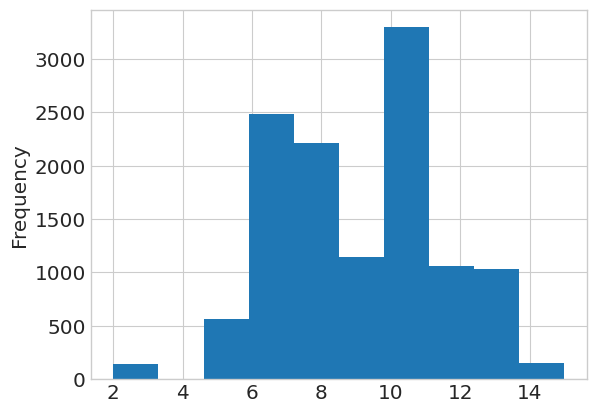

In [12]:
aging_new_extract['DEMOGRAPHICS-day0_age'].plot(kind='hist')

In [13]:
aging_new_extract['EXCESSIVE_RUNNING'].value_counts()

0    13502
1      468
Name: EXCESSIVE_RUNNING, dtype: int64

In [14]:
aging_new_extract.columns[:30]

Index(['PET_ID', 'EXTERNAL_ID', 'DEVICE_ID', 'STUDY_ID', 'STUDY_NAME',
       'PET_NAME', 'DATE', 'NORMALIZED_STUDY_DAY',
       'NORMALIZED_QUALIFYING_STUDY_DAY', 'STUDY_DAY_COUNTER', 'STUDY_GROUP',
       'BASELINE_START', 'START_DATE', 'ENROLLMENT_DATE', 'COMPLETION_DATE',
       'END_DATE', 'EXCESSIVE_RUNNING', 'TIMEZONE', 'QUALIFYING_DATA_DAY',
       'IS_QUALIFIED', 'DAILYDATAQUALITYINDREASON', 'VAR_TD_1_Q1_2',
       'VAR_CE_1_Q1_2', 'VAR_MIN_1_Q1_2', 'VAR_MED_1_Q1_2', 'VAR_RANG_1_Q1_2',
       'VAR_MAX_1_Q1_2', 'VAR_AVG_1_Q1_2', 'VAR_SD_1_Q1_2', 'VAR_IQR_1_Q1_2'],
      dtype='object')

## Basic EDA

### Excessive running

In [15]:
aging_new_extract['EXCESSIVE_RUNNING'].value_counts()

0    13502
1      468
Name: EXCESSIVE_RUNNING, dtype: int64

### Is qualified

In [16]:
aging_new_extract['IS_QUALIFIED'].value_counts()

YES    11397
NO      2573
Name: IS_QUALIFIED, dtype: int64

### Study group

In [17]:
aging_new_extract['STUDY_GROUP'].value_counts(dropna=False)

Unassigned    8454
Peach         2974
Black         2542
Name: STUDY_GROUP, dtype: int64

### Normalized qualifying study day

In [18]:
aging_new_extract['NORMALIZED_QUALIFYING_STUDY_DAY'].isna().sum()

2573

### Patient days

### Number of baseline and treatment days

In [19]:
aging_new_extract['study_period'] = [
    'baseline_period' if (x < 0 and x >= -21) 
    else 'treatment_period' if (x >= 0 and x <= 63)
    else 'post_treatment_period'
    for x in aging_new_extract['NORMALIZED_QUALIFYING_STUDY_DAY_NEW'].values
]

In [20]:
baseline_treatment_days_patient=[]
for x in pd.DataFrame(aging_new_extract['EXTERNAL_ID'].unique()).dropna()[0].values:
    sample_patient=aging_new_extract[aging_new_extract['EXTERNAL_ID']==x]
    baseline_days=sample_patient[sample_patient['NORMALIZED_QUALIFYING_STUDY_DAY_NEW']<0]['DATE'].nunique()
    treatment_days=sample_patient[sample_patient['NORMALIZED_QUALIFYING_STUDY_DAY_NEW']>=0]['DATE'].nunique()
    baseline_treatment_days_patient.append([sample_patient['PET_ID'].unique()[0],
                                            sample_patient['study_food'].unique()[0],
                                            x,baseline_days,treatment_days])
baseline_treatment_days=pd.DataFrame(baseline_treatment_days_patient)
baseline_treatment_days.columns=['PET_ID','study_food','external_patient_id','baseline_days','treatment_days']

In [21]:
baseline_treatment_days.head()

,PET_ID,study_food,external_patient_id,baseline_days,treatment_days
0,3347,Peach,EPRO-QT-02,17,96
1,3348,None,EPRO-AD2-07,0,0
2,3349,None,EPRO-WVH-06,5,2
3,3350,Black,EPRO-WVH-05,28,94
4,3391,None,EPRO-AD-02,0,0


In [22]:
baseline_treatment_days.shape

(146, 5)

In [23]:
baseline_treatment_pp_itt_merge = pd.merge(baseline_treatment_days,
                                            population,
                                            how='left',
                                            on='PET_ID')

In [24]:
baseline_treatment_pp_itt_merge['wearables_pp'].value_counts()

False    104
True      42
Name: wearables_pp, dtype: int64

In [25]:
baseline_treatment_pp_itt_merge['wearables_itt'].value_counts()

True     145
False      1
Name: wearables_itt, dtype: int64

In [26]:
patients_with_less_than_3_weeks = baseline_treatment_pp_itt_merge[(baseline_treatment_pp_itt_merge\
                                                                      ['baseline_days']<21) |\
                                (baseline_treatment_pp_itt_merge['treatment_days']<21)]\
                                    ['external_patient_id'].unique()
patients_with_less_than_3_weeks

array(['EPRO-QT-02', 'EPRO-AD2-07', 'EPRO-WVH-06', 'EPRO-AD-02',
       'EPRO-WVH-04', 'EPRO-CH-01', 'EPRO-AD2-09', 'EPRO-QT-18',
       'EPRO-QT-17', 'EPRO-BR-06', 'EPRO-QT-07', 'EPRO-AD2-01',
       'EPRO-QT-12', 'EPRO-QT-13', 'EPRO-SVC-04', 'EPRO-SVC-03',
       'EPRO-AD-04', 'EPRO-AD2-04', 'EPRO-AD2-06', 'EPRO-QT-15',
       'EPRO-QT-16', 'EPRO-EAH-01', 'EPRO-QT-04', 'EPRO-EAH-05',
       'EPRO-EAH-08', 'EPRO-EAH-09', 'EPRO-WVH-01', 'EPRO-NF-05',
       'EPRO-TV-03', 'EPRO-TV-01', 'EPRO-TV-04', 'EPRO-TV-05',
       'EPRO-TV-08', 'EPRO-LB-01', 'EPRO-LB-02', 'EPRO-LB-03',
       'EPRO-JA-09', 'EPRO-SH-01', 'EPRO-JA-14', 'EPRO-ER-02',
       'EPRO-LB-10', 'EPRO-LB-09', 'EPRO-CM-05', 'EPRO-EE-02',
       'EPRO-QU-04', 'EPRO-QU-08', 'EPRO-QU-07', 'EPRO-QU-16',
       'EPRO-LB-12', 'EPRO-QU-11', 'EPRO-EE-06', 'EPRO-QU-25',
       'EPRO-QU-18', 'EPRO-EE-07', 'EPRO-JA-22', 'EPRO-QU-27',
       'EPRO-JA-27', 'EPRO-JA-30', 'EPRO-JA-31', 'EPRO-JA-34',
       'EPRO-JA-38', 'EPRO-EE-12', 'EPRO-

In [27]:
baseline_treatment_wo_less_than_3_weeks = baseline_treatment_pp_itt_merge[(~baseline_treatment_pp_itt_merge\
                                 ['external_patient_id']\
                                 .isin(patients_with_less_than_3_weeks))]

In [28]:
baseline_treatment_wo_less_than_3_weeks[baseline_treatment_wo_less_than_3_weeks['wearables_pp']==True]\
                                    ['study_food'].value_counts()

Black    21
Peach    18
Name: study_food, dtype: int64

In [29]:
baseline_treatment_wo_less_than_3_weeks[baseline_treatment_wo_less_than_3_weeks['wearables_itt']==True]\
                                    ['study_food'].value_counts()

Peach    43
Black    37
None      2
Name: study_food, dtype: int64

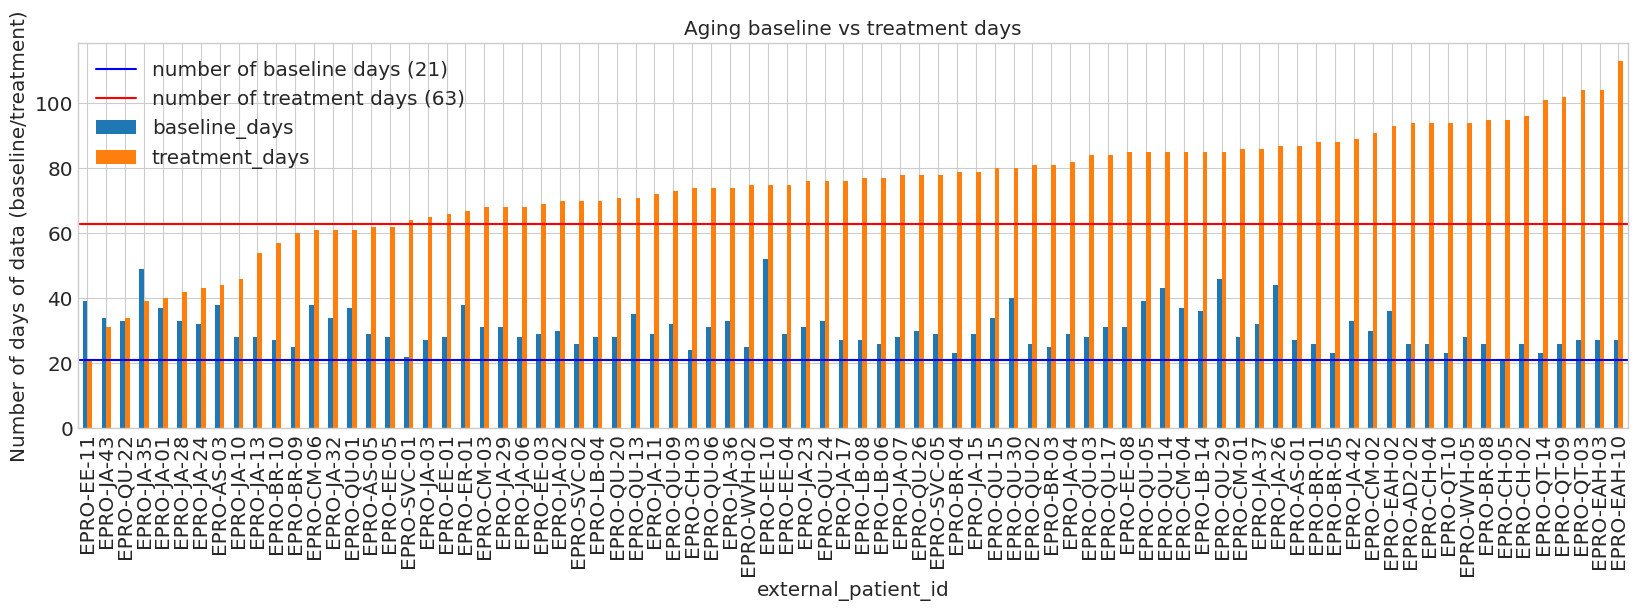

In [30]:
baseline_treatment_wo_less_than_3_weeks.index=baseline_treatment_wo_less_than_3_weeks['external_patient_id']
baseline_treatment_wo_less_than_3_weeks=baseline_treatment_wo_less_than_3_weeks.sort_values(['treatment_days'])
baseline_treatment_wo_less_than_3_weeks[['baseline_days','treatment_days']].plot(kind='bar',figsize=(20,5))
plt.axhline(y=21, color='b', linestyle='-', label='number of baseline days (21)')
plt.axhline(y=63, color='r', linestyle='-', label='number of treatment days (63)')
plt.title("Aging baseline vs treatment days")
plt.ylabel('Number of days of data (baseline/treatment)')
plt.legend()

# Sampling criteria

In [31]:
aging_new_extract.groupby(['study_food','wearables_pp','wearables_itt']).agg({'PET_ID':'nunique'})

PET_ID
study_food wearables_pp wearables_itt        
Black      False        True               33
           True         True               22
None       False        False               1
                        True               36
Peach      False        True               34
           True         True               20

In [32]:
aging_new_extract = aging_new_extract[(aging_new_extract['IS_QUALIFIED_NEW']=='YES') &\
                                      (aging_new_extract['study_food'].isin(['Black','Peach'])) &\
                                      (~aging_new_extract['EXTERNAL_ID'].isin(patients_with_less_than_3_weeks)) &\
                                      (aging_new_extract['EXCESSIVE_RUNNING']==0)]

In [33]:
aging_new_extract.groupby(['study_food','wearables_pp','wearables_itt']).agg({'PET_ID':'nunique'})

PET_ID
study_food wearables_pp wearables_itt        
Black      False        True               16
           True         True               21
Peach      False        True               25
           True         True               18

## Norm excursion

### Sampling criteria

In [34]:
aging_new_extract['external_patient_id'] = aging_new_extract['EXTERNAL_ID']
aging_new_extract['study_group'] = aging_new_extract['study_food']

In [35]:
aging_new_extract['normalized_qualifying_study_day'] = aging_new_extract['NORMALIZED_QUALIFYING_STUDY_DAY_NEW']\
                                                            .replace(' ',np.nan).astype(float)

In [36]:
study_name='Aging'
pp_sampling_criteria=list(aging_new_extract[aging_new_extract['wearables_pp']==True]\
                          ['external_patient_id'].unique())
itt_sampling_criteria=list(aging_new_extract[aging_new_extract['wearables_itt']==True]\
                          ['external_patient_id'].unique())
sampling_criteria=set(pp_sampling_criteria)

group_1='Black'
group_2='Peach'
black_color='black'
peach_color='#FFDAB9'

In [37]:
len(sampling_criteria)

39

### Meta data

In [38]:
meta_data=StudyMetaData(study_name,sampling_criteria,group_1,group_2,black_color,peach_color)

In [39]:
print(meta_data.study_name)
print(meta_data.sampling_criteria)
print(meta_data.group_1)
print(meta_data.group_2)
print(meta_data.color_1)
print(meta_data.color_2)

Aging
{'EPRO-JA-15', 'EPRO-EAH-03', 'EPRO-QT-03', 'EPRO-EAH-10', 'EPRO-QU-20', 'EPRO-JA-42', 'EPRO-QT-10', 'EPRO-JA-17', 'EPRO-QU-14', 'EPRO-EE-08', 'EPRO-QU-09', 'EPRO-SVC-05', 'EPRO-QU-13', 'EPRO-LB-14', 'EPRO-QT-14', 'EPRO-QU-26', 'EPRO-JA-06', 'EPRO-EE-10', 'EPRO-QU-15', 'EPRO-BR-01', 'EPRO-AD2-02', 'EPRO-QU-05', 'EPRO-WVH-05', 'EPRO-JA-29', 'EPRO-LB-04', 'EPRO-LB-06', 'EPRO-JA-23', 'EPRO-QU-02', 'EPRO-JA-26', 'EPRO-LB-08', 'EPRO-QU-06', 'EPRO-QU-30', 'EPRO-JA-04', 'EPRO-JA-11', 'EPRO-QU-17', 'EPRO-CM-01', 'EPRO-QT-09', 'EPRO-QU-24', 'EPRO-QU-29'}
Black
Peach
black
#FFDAB9


### Data validation

In [40]:
new_aging_df = aging_new_extract[aging_new_extract['external_patient_id'].isin(sampling_criteria)].copy()

In [41]:
activity_map = {
    'VAR_TD_1_Q5_2': 'Resting',
    'VAR_TD_3_Q5_2': 'Running',
    'VAR_TD_5_Q5_2': 'Scratching',
    'VAR_TD_4_Q5_2': 'Shaking',
    'VAR_TD_12_Q5_2': 'Sleep',
    'VAR_TD_2_Q5_2': 'Walking'
}

In [42]:
for x in activity_map.items():
    print(x)
    new_aging_df[x[1]] = new_aging_df[x[0]]

('VAR_TD_1_Q5_2', 'Resting')
('VAR_TD_3_Q5_2', 'Running')
('VAR_TD_5_Q5_2', 'Scratching')
('VAR_TD_4_Q5_2', 'Shaking')
('VAR_TD_12_Q5_2', 'Sleep')
('VAR_TD_2_Q5_2', 'Walking')


In [43]:
DataValidation(new_aging_df).data_validation()

Validation checks:

1) Validation check fails

Note: Below are the missing columns from the extract:

{'normalized_study_day'}


2) Validation check fails (dtypes)

Note: Consider including missing columns from validation check (1) and try again.


### Study groups

In [44]:
group_1_names=new_aging_df[new_aging_df['study_group']=='Black']\
                                    ['external_patient_id'].unique()
group_2_names=new_aging_df[new_aging_df['study_group']=='Peach']\
                                    ['external_patient_id'].unique()

In [45]:
group_1_names

array(['EPRO-WVH-05', 'EPRO-BR-01', 'EPRO-AD2-02', 'EPRO-QT-03',
       'EPRO-EAH-10', 'EPRO-JA-04', 'EPRO-JA-06', 'EPRO-LB-04',
       'EPRO-JA-15', 'EPRO-LB-08', 'EPRO-CM-01', 'EPRO-QU-05',
       'EPRO-QU-06', 'EPRO-QU-14', 'EPRO-QU-15', 'EPRO-LB-14',
       'EPRO-QU-24', 'EPRO-JA-26', 'EPRO-QU-29', 'EPRO-JA-29',
       'EPRO-QU-30'], dtype=object)

In [46]:
group_2_names

array(['EPRO-QT-09', 'EPRO-QT-10', 'EPRO-SVC-05', 'EPRO-QT-14',
       'EPRO-EAH-03', 'EPRO-JA-11', 'EPRO-LB-06', 'EPRO-JA-17',
       'EPRO-QU-02', 'EPRO-QU-13', 'EPRO-QU-09', 'EPRO-QU-17',
       'EPRO-QU-20', 'EPRO-JA-23', 'EPRO-EE-08', 'EPRO-QU-26',
       'EPRO-EE-10', 'EPRO-JA-42'], dtype=object)

In [47]:
len(group_1_names)

21

In [48]:
len(group_2_names)

18

### Impute null values with zero

In [49]:
new_aging_df = new_aging_df.fillna(0)

In [50]:
new_aging_df['study_group'].value_counts()

Black    2440
Peach    2026
Name: study_group, dtype: int64

### Parameters

In [51]:
# One class svm parameters
one_class_params={'kernel':'linear',
                  'degree':3,
                  'gamma':'scale', 
                  'coef0':0.0, 
                  'tol':0.001, 
                  'nu':0.5, 
                  'shrinking':True, 
                  'max_iter':- 1}
# Whether to scale input features
scale_input_data=False
# Meta columns describing data
meta_columns=['external_patient_id','normalized_qualifying_study_day','study_group']
# Input features on which norm excursion would be fit
input_features=['VAR_TD_1_Q5_2','VAR_TD_3_Q5_2','VAR_TD_5_Q5_2', 'VAR_TD_4_Q5_2','VAR_TD_12_Q5_2','VAR_TD_2_Q5_2']

### Analysis

In [52]:
weekly_patient_analysis=[]
daily_patient_analysis=[]
for patient_name in new_aging_df['external_patient_id'].unique():
    try:
        # Columns list
        features_tinker=meta_columns+input_features
        # Filter the patient
        sample_patient=new_aging_df[new_aging_df['external_patient_id']==patient_name]\
                                                            [features_tinker]\
                                                            .reset_index().drop(['index'],axis=1)
        sample_patient.index=sample_patient['normalized_qualifying_study_day']
        sample_patient = sample_patient.sort_index()
        # Baseline period 
        baseline_period=sample_patient[(sample_patient['normalized_qualifying_study_day']<0) &
                                      (sample_patient['normalized_qualifying_study_day']>=-21)]\
                                    .drop(['normalized_qualifying_study_day','external_patient_id',\
                                                                'study_group'],axis=1)
        # Treatment period
        treatment_period=sample_patient[(sample_patient['normalized_qualifying_study_day']>=0) &
                                      (sample_patient['normalized_qualifying_study_day']<=63)]\
                                    .drop(['normalized_qualifying_study_day','external_patient_id',\
                                                                'study_group'],axis=1)
        # Whether to perform scaling on baseline period input features
        if scale_input_data:
            scaler=MinMaxScaler()
            baseline_period=scaler.fit_transform(baseline_period)
            treatment_period=scaler.transform(treatment_period)

        # NormExcursion custom model fit on single patient (baseline period) using patient name and params
        model=NormExcursion(patient_name,**one_class_params).fit(baseline_period)

        # Saving predictions on treatment period from NormExcursion model fitted earlier
        daily_success, weekly_success=model.predict(treatment_period)

        # Append to master list
        weekly_patient_analysis.append(weekly_success)
        daily_patient_analysis.append(daily_success)
    except:
        print(patient_name)

In [53]:
weekly_success_df = pd.concat(weekly_patient_analysis).pivot(
    index='week_name', columns='external_patient_id',
    values='percent_of_success_days')

In [54]:
group_1_names

array(['EPRO-WVH-05', 'EPRO-BR-01', 'EPRO-AD2-02', 'EPRO-QT-03',
       'EPRO-EAH-10', 'EPRO-JA-04', 'EPRO-JA-06', 'EPRO-LB-04',
       'EPRO-JA-15', 'EPRO-LB-08', 'EPRO-CM-01', 'EPRO-QU-05',
       'EPRO-QU-06', 'EPRO-QU-14', 'EPRO-QU-15', 'EPRO-LB-14',
       'EPRO-QU-24', 'EPRO-JA-26', 'EPRO-QU-29', 'EPRO-JA-29',
       'EPRO-QU-30'], dtype=object)

<AxesSubplot:xlabel='week_name'>

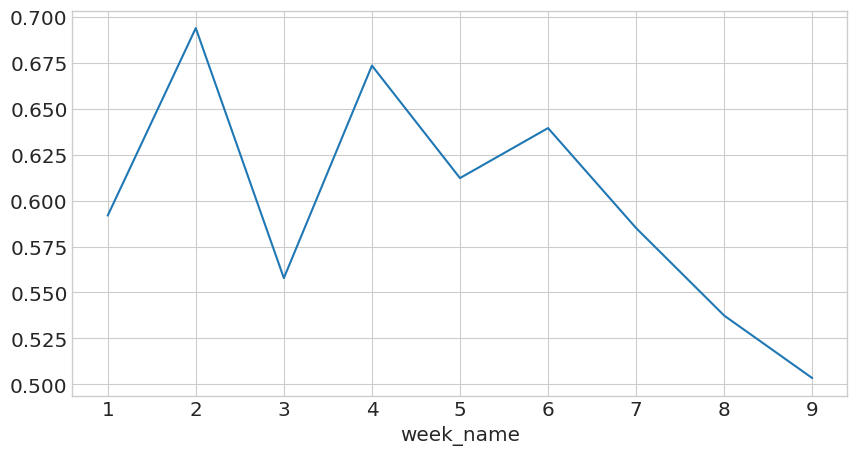

In [55]:
weekly_success_df[group_1_names].mean(axis=1).plot(figsize=(10,5))

In [56]:
weekly_success_df

external_patient_id,EPRO-AD2-02,EPRO-BR-01,EPRO-CM-01,EPRO-EAH-03,EPRO-EAH-10,EPRO-EE-08,EPRO-EE-10,EPRO-JA-04,EPRO-JA-06,EPRO-JA-11,EPRO-JA-15,EPRO-JA-17,EPRO-JA-23,EPRO-JA-26,EPRO-JA-29,EPRO-JA-42,EPRO-LB-04,EPRO-LB-06,EPRO-LB-08,EPRO-LB-14,EPRO-QT-03,EPRO-QT-09,EPRO-QT-10,EPRO-QT-14,EPRO-QU-02,EPRO-QU-05,EPRO-QU-06,EPRO-QU-09,EPRO-QU-13,EPRO-QU-14,EPRO-QU-15,EPRO-QU-17,EPRO-QU-20,EPRO-QU-24,EPRO-QU-26,EPRO-QU-29,EPRO-QU-30,EPRO-SVC-05,EPRO-WVH-05
week_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.857143,0.428571,0.571429,0.714286,0.714286,0.428571,1.000000,0.857143,0.857143,0.428571,0.714286,0.857143,0.857143,0.714286,0.428571,0.285714,0.714286,0.714286,0.571429,1.000000,0.714286,1.000000,0.714286,1.000000,0.571429,0.428571,0.714286,0.428571,0.428571,0.142857,0.428571,0.142857,0.285714,0.714286,0.714286,0.142857,0.285714,0.571429,0.428571
2,0.571429,0.571429,0.714286,0.857143,0.857143,0.285714,0.857143,0.428571,1.000000,0.000000,0.857143,1.000000,0.571429,0.857143,0.714286,0.571429,0.571429,0.714286,1.000000,1.000000,0.571429,1.000000,0.571429,1.000000,0.285714,0.571429,0.571429,0.428571,0.857143,0.000000,0.714286,0.714286,0.285714,1.000000,0.571429,0.714286,0.714286,0.571429,0.571429
3,0.714286,0.714286,0.714286,0.714286,0.285714,0.714286,0.285714,0.142857,1.000000,0.000000,0.428571,0.571429,0.571429,0.571429,0.571429,1.000000,0.857143,0.571429,0.714286,0.714286,0.428571,0.428571,0.714286,0.857143,0.428571,0.571429,0.000000,0.285714,0.142857,0.285714,0.428571,0.714286,0.285714,1.000000,0.714286,0.857143,0.428571,0.428571,0.285714
4,0.714286,0.714286,0.714286,0.714286,0.857143,0.571429,0.714286,1.000000,0.714286,0.571429,0.857143,0.571429,0.428571,0.714286,0.714286,0.428571,0.714286,0.857143,0.714286,1.000000,0.714286,0.857143,0.857143,0.714286,0.285714,0.571429,0.428571,0.571429,0.142857,0.000000,0.571429,0.285714,0.285714,0.571429,0.285714,0.714286,0.571429,0.571429,0.571429
5,0.857143,0.571429,0.285714,0.857143,0.857143,0.571429,0.714286,1.000000,0.714286,0.571429,0.857143,0.428571,0.571429,0.428571,0.428571,0.142857,0.571429,0.428571,0.571429,1.000000,0.428571,0.571429,0.714286,1.000000,0.428571,0.571429,0.714286,0.571429,0.428571,0.142857,0.285714,0.714286,0.285714,1.000000,0.571429,0.571429,0.571429,0.285714,0.428571
6,0.857143,0.428571,0.571429,0.857143,0.857143,0.428571,0.571429,1.000000,1.000000,0.428571,0.857143,0.571429,0.428571,0.428571,0.571429,0.714286,0.714286,0.571429,0.714286,0.714286,0.714286,0.714286,0.714286,0.714286,0.285714,0.857143,0.571429,0.857143,0.571429,0.142857,0.142857,0.714286,0.142857,0.714286,0.428571,0.714286,0.428571,0.285714,0.428571
7,0.857143,1.000000,0.428571,0.857143,0.285714,0.000000,0.285714,0.571429,0.857143,0.714286,0.857143,0.285714,0.571429,0.142857,0.285714,0.285714,0.428571,0.857143,0.714286,1.000000,0.428571,0.571429,0.857143,0.714286,0.428571,0.428571,0.857143,0.285714,0.571429,0.285714,0.428571,0.714286,0.285714,0.714286,0.714286,1.000000,0.142857,0.285714,0.571429
8,0.571429,0.285714,0.571429,0.857143,0.571429,0.571429,0.428571,0.714286,0.857143,0.428571,0.571429,0.714286,0.571429,0.571429,0.428571,0.142857,0.571429,0.857143,0.857143,0.857143,0.428571,0.571429,0.571429,0.857143,0.571429,0.571429,0.571429,0.571429,0.428571,0.285714,0.142857,0.571429,0.714286,1.000000,0.714286,0.142857,0.285714,0.285714,0.428571
9,0.571429,0.571429,0.428571,0.428571,0.571429,0.142857,0.714286,1.000000,0.857143,0.142857,0.714286,0.428571,0.285714,0.142857,0.142857,0.428571,0.285714,0.285714,0.428571,0.857143,0.285714,0.571429,0.857143,0.714286,0.428571,0.285714,0.571429,0.571429,0.571429,0.285714,0.142857,0.428571,0.285714,1.000000,0.571429,0.428571,0.285714,0.428571,0.714286


In [57]:
weekly_patient_analysis[0]

,week_name,percent_of_success_days,external_patient_id
0,1,0.428571,EPRO-WVH-05
1,2,0.571429,EPRO-WVH-05
2,3,0.285714,EPRO-WVH-05
3,4,0.571429,EPRO-WVH-05
4,5,0.428571,EPRO-WVH-05
5,6,0.428571,EPRO-WVH-05
6,7,0.571429,EPRO-WVH-05
7,8,0.428571,EPRO-WVH-05
8,9,0.714286,EPRO-WVH-05


### Results

In [58]:
report_result=ReportResults(daily_patient_analysis,weekly_patient_analysis,\
                        group_1_names,group_2_names,\
                        group_1,group_2,\
                        meta_data.color_1,meta_data.color_2,\
                        84,\
                        0.05)

#### Weekly treatment effects

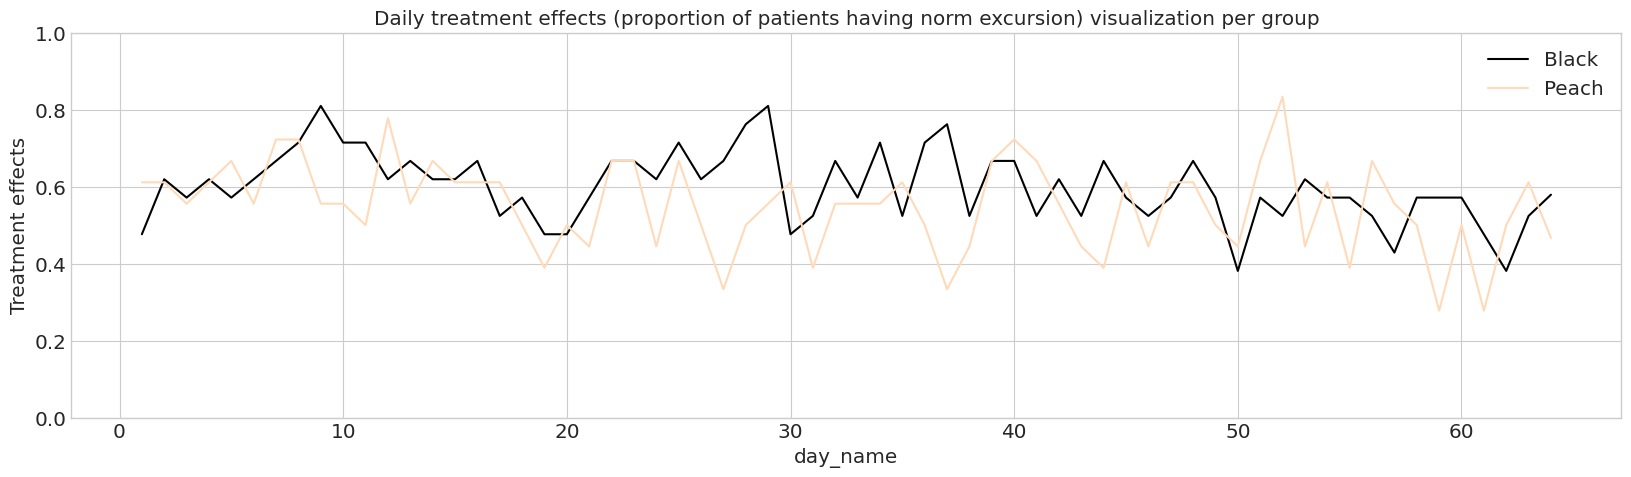

In [59]:
report_result.visualize_treatment_effect(True,84,12)

Text(0, 0.5, 'Proportion of outlier days (averaged per group)')

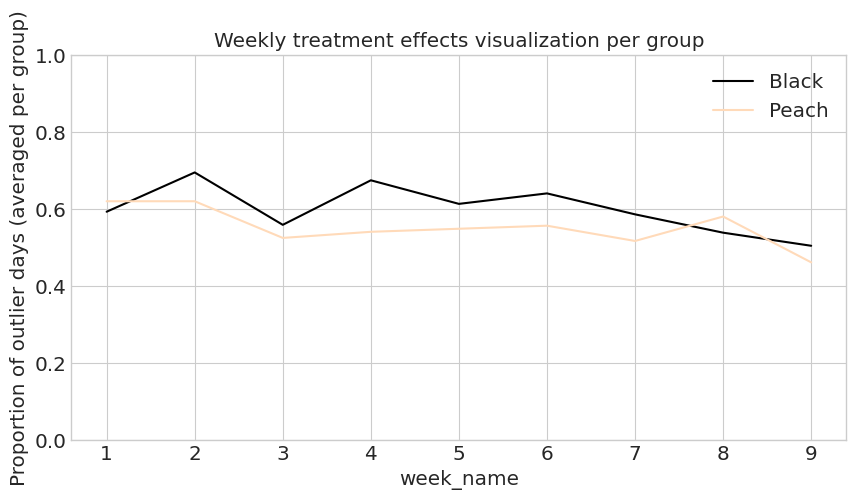

In [60]:
report_result.visualize_treatment_effect(False,84,12)
plt.ylabel('Proportion of outlier days (averaged per group)')

#### Daily treatment effects

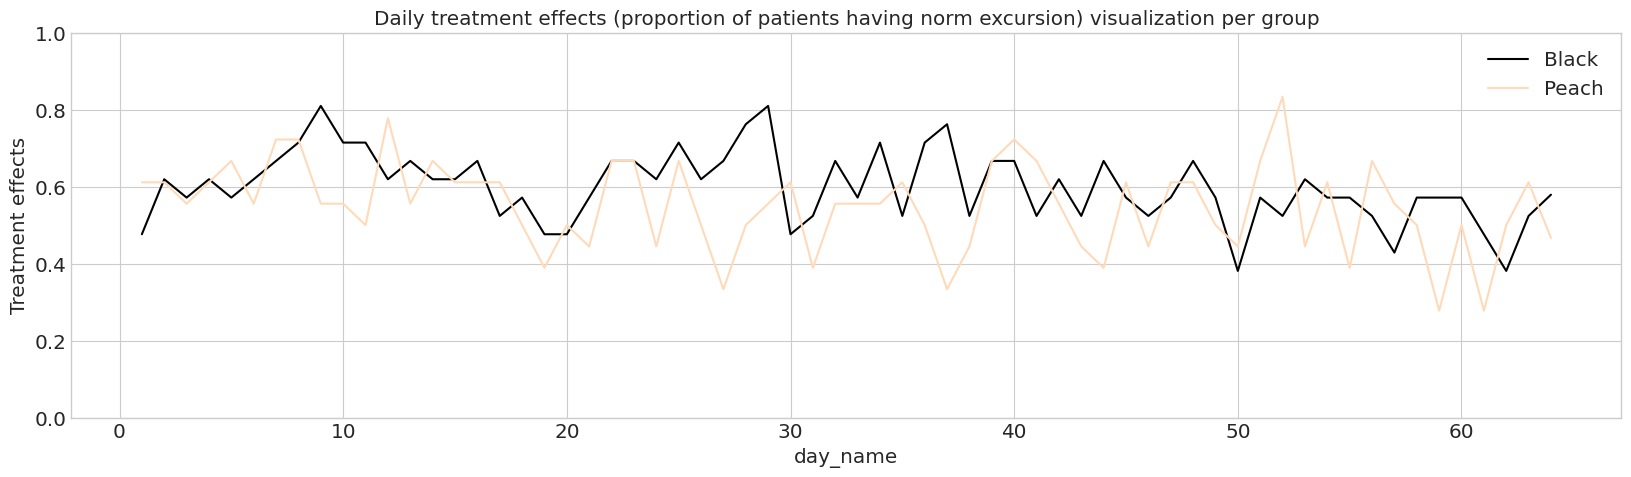

In [61]:
report_result.visualize_treatment_effect(True,84,12)

#### T-test

In [62]:
report_result.report_ttest_statistic(True)

                       T-test Assumptions                      
                                          Success/Fails P-value
---------------------------------------------------------------
1) Test for equality of variance (levene)       Success  0.6519
2) Test for normality (shapiro)                 Success        
 a) Group 1                                              0.7500
 b) Group 2                                              0.7600
---------------------------------------------------------------
Levene test
The Levene test tests the null hypothesis that all input 
samples are from populations with equal variances.
---------------------------------------------------------------
Shapiro test
The Shapiro-Wilk test tests the null hypothesis that the 
data was drawn from a normal distribution.
---------------------------------------------------------------



        T-test (difference in proportion of outlier)       
        Statistic P-value             Conclusion           
--

#### Mann whitney test

In [63]:
report_result.mann_whitney_test()

MannwhitneyuResult(statistic=224.5, pvalue=0.32383257291557666)

#### Fraction of outlier (histogram)

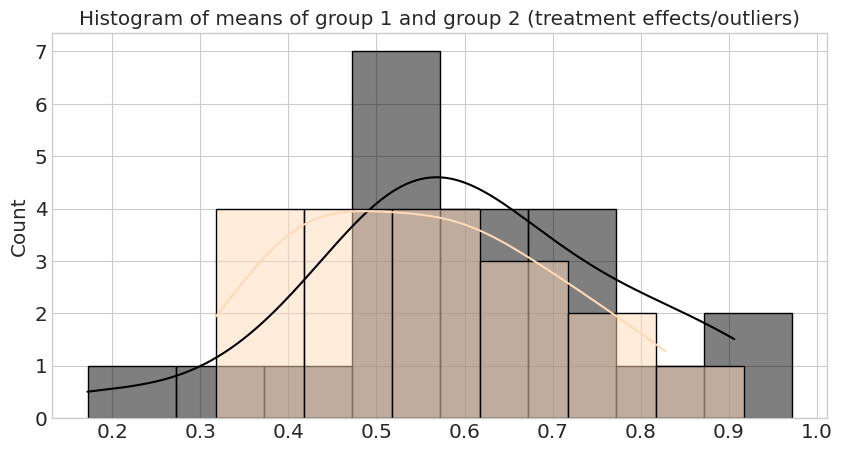

In [64]:
report_result.plot_fraction_of_outlier_hist()

#### Binomial confidence interval

In [65]:
report_result.report_confidence_interval()

Group 1 confidence interval (Based on fraction of outlier) (0.5728849807118738, 0.625326643729259)
Group 2 confidence interval (Based on fraction of outlier) (0.5212774920641532, 0.5788095401377615)


#### Binomial test for difference in proportion

In [66]:
report_result.binomial_test(0.05,False)

H0: P1=P2 (p1 is same as p2)
Ha: P1!=P2 (p1 is not same as p2)

Results:
P-value: 0.01349614524701698431
Reject the null hypothesis that p1 is the same as p2.
There is significant difference


In [67]:
report_result.binomial_test(0.05,True)

{'p1': 0.5991058122205664, 'p2': 0.5500435161009574, 'n1': 1342, 'n2': 1149}

#### Means of groups

In [68]:
group_1_means,group_2_means = report_result.report_ttest_statistic(False)

In [69]:
group_1_means

[0.5,
 0.59375,
 0.71875,
 0.53125,
 0.640625,
 0.75,
 0.875,
 0.6031746031746031,
 0.75,
 0.6875,
 0.5625,
 0.53125,
 0.5625,
 0.171875,
 0.359375,
 0.90625,
 0.859375,
 0.5,
 0.59375,
 0.47619047619047616,
 0.40625]

In [70]:
group_2_means

[0.703125,
 0.71875,
 0.421875,
 0.828125,
 0.765625,
 0.375,
 0.640625,
 0.59375,
 0.4126984126984127,
 0.453125,
 0.515625,
 0.546875,
 0.31746031746031744,
 0.546875,
 0.40625,
 0.5873015873015873,
 0.625,
 0.4375]

#### Effect size

In [71]:
power_analysis=PowerAnalysis()
print("Effect size:",power_analysis.get_cohend_effectsize(group_1_means,
                                                         group_2_means))

Effect size: 0.3014248391428289


#### Randomization test


Randomization test results:

Original difference between group 1 and group 2: 0.04926264487276388
p-value: 0.1758
Result: randomization test suggests no significant difference between two groups.


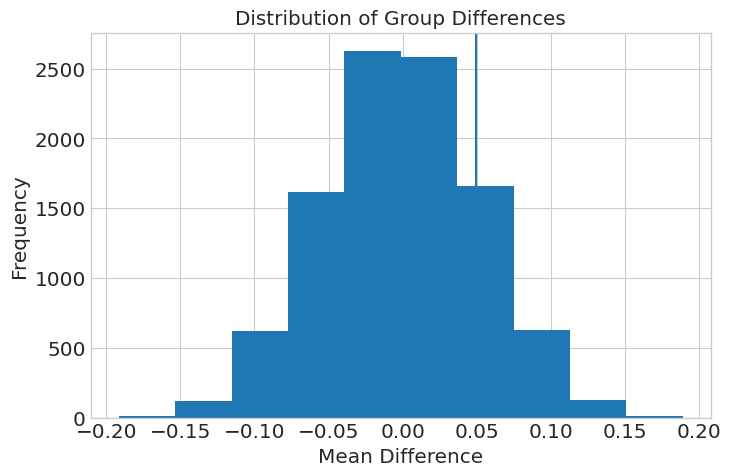

In [72]:
responder_utils.randomization_test(group_1_means, group_2_means, 
                   10000, 0.05,False)